Mean is: 42249.527
Next mean is: 43048.897333333334


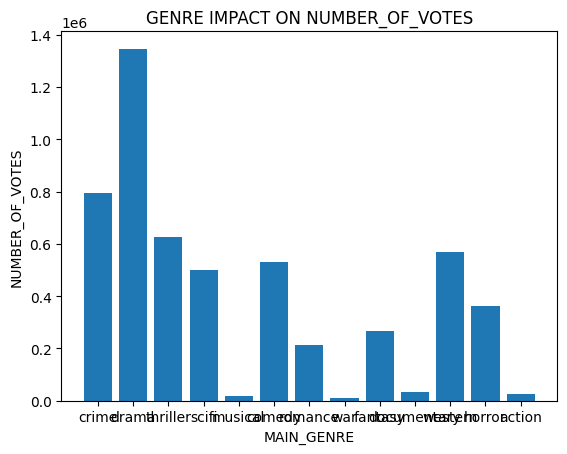

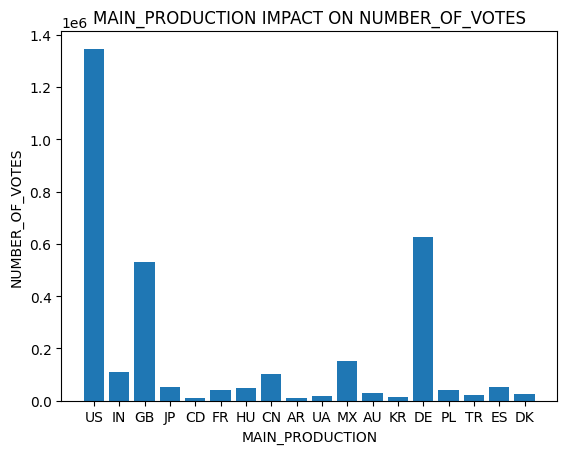

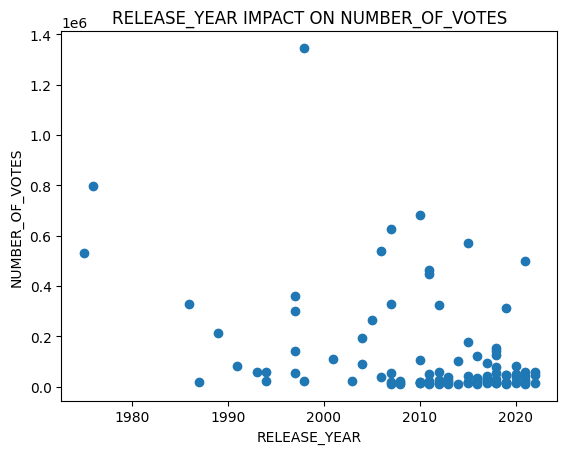

C:\Users\USER\AppData\Local\Temp\ipykernel_19940\1730943118.py:72: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill to handle missing values
C:\Users\USER\AppData\Local\Temp\ipykernel_19940\1730943118.py:73: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Backward fill if still missing


Data before cleaning:
     index                               TITLE  RELEASE_YEAR  SCORE  \
193    193  Sherlock Holmes: A Game of Shadows          2011    7.4   
130    130                           Rock On!!          2008    7.7   
60      60                       Blood Diamond          2006    8.0   
301    301          Black Mirror: Bandersnatch          2018    7.1   
112    112                         Madras Cafe          2013    7.7   

     NUMBER_OF_VOTES  DURATION MAIN_GENRE MAIN_PRODUCTION    random  
193           446531       129      crime              US  0.002356  
130            21963       144      drama              IN  0.004782  
60            536858       143   thriller              US  0.008314  
301           123377        90      scifi              GB  0.008325  
112            24319       130   thriller              IN  0.009846  
Data after cleaning:
     index                               TITLE  RELEASE_YEAR  SCORE  \
193    193  Sherlock Holmes: A Game of 

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the dataset
netflix_movies = pd.read_csv(r'C://Users//USER//Downloads//Documents//Best Movies Netflix.csv')

# Remove duplicates
netflix_movies.drop_duplicates(inplace=True)

# Generate and sort by random numbers
netflix_movies['random'] = np.random.rand(len(netflix_movies))
netflix_movies.sort_values(by='random', inplace=True)

# Select the first 100 random observations
random_sample = netflix_movies.head(100)

# Select columns with integer values
selected_columns = ['RELEASE_YEAR', 'SCORE', 'NUMBER_OF_VOTES']
selected_data = random_sample[selected_columns]

# Calculate the mean
mean_values = selected_data.mean()
a = mean_values.mean()
print("Mean is:", a)

# Generate new random numbers and sort again
netflix_movies['random'] = np.random.rand(len(netflix_movies))
netflix_movies.sort_values(by='random', inplace=True)

# Select the next 100 random observations
next_random_sample = netflix_movies.head(100)
next_selected_data = next_random_sample[selected_columns]

# Calculate the mean for the next sample
next_mean_values = next_selected_data.mean()
b = next_mean_values.mean()
print("Next mean is:", b)

# Plotting features
plt.bar(random_sample['MAIN_GENRE'].fillna('Unknown'), random_sample['NUMBER_OF_VOTES'])
plt.xlabel('MAIN_GENRE')
plt.ylabel('NUMBER_OF_VOTES')
plt.title('GENRE IMPACT ON NUMBER_OF_VOTES')
plt.show()

plt.bar(random_sample['MAIN_PRODUCTION'].fillna('Unknown'), random_sample['NUMBER_OF_VOTES'])
plt.xlabel('MAIN_PRODUCTION')
plt.ylabel('NUMBER_OF_VOTES')
plt.title('MAIN_PRODUCTION IMPACT ON NUMBER_OF_VOTES')
plt.show()

plt.scatter(random_sample['RELEASE_YEAR'], random_sample['NUMBER_OF_VOTES'])
plt.xlabel('RELEASE_YEAR')
plt.ylabel('NUMBER_OF_VOTES')
plt.title('RELEASE_YEAR IMPACT ON NUMBER_OF_VOTES')
plt.show()

# Clean data with imputation
def clean_data(df):
    df = df.copy()
    df.fillna(method='ffill', inplace=True)  # Forward fill to handle missing values
    df.fillna(method='bfill', inplace=True)  # Backward fill if still missing
    return df

sample1_clean = clean_data(random_sample)
sample2_clean = clean_data(next_random_sample)

# Print data before and after cleaning
print("Data before cleaning:")
print(random_sample.head())

print("Data after cleaning:")
print(sample1_clean.head())

print("Data before cleaning:")
print(next_random_sample.head())

print("Data after cleaning:")
print(sample2_clean.head())

# Check variance and sample size
print("Sample 1 variance:")
print(sample1_clean[selected_columns].var())
print("Sample 1 size:", len(sample1_clean))

print("Sample 2 variance:")
print(sample2_clean[selected_columns].var())
print("Sample 2 size:", len(sample2_clean))

# Perform one-sample t-tests
if len(sample1_clean) > 1 and sample1_clean['NUMBER_OF_VOTES'].var() > 0:
    t_statistic1, p_value1 = stats.ttest_1samp(sample1_clean['NUMBER_OF_VOTES'], popmean=25)
else:
    t_statistic1, p_value1 = np.nan, np.nan
print(f"One-sample t-test for sample 1: t-statistic = {t_statistic1:.4f}, p-value = {p_value1:.4f}")

if len(sample2_clean) > 1 and sample2_clean['NUMBER_OF_VOTES'].var() > 0:
    t_statistic2, p_value2 = stats.ttest_1samp(sample2_clean['NUMBER_OF_VOTES'], popmean=25)
else:
    t_statistic2, p_value2 = np.nan, np.nan
print(f"One-sample t-test for sample 2: t-statistic = {t_statistic2:.4f}, p-value = {p_value2:.4f}")

# Perform chi-square test if data is available
if len(sample1_clean) > 0 and 'MAIN_PRODUCTION' in sample1_clean.columns and 'MAIN_GENRE' in sample1_clean.columns:
    contingency_table = pd.crosstab(sample1_clean['MAIN_PRODUCTION'], sample1_clean['MAIN_GENRE'])
    chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi-square test: chi2-statistic = {chi2_statistic:.4f}, p-value = {p_value:.4f}")
else:
    print("Sample 1 is empty or missing necessary columns for chi-square test.")

# SQLite connection
conn = sqlite3.connect('mydatabase.db')
cursor = conn.cursor()

# Write DataFrame to SQL table
netflix_movies.to_sql('Best_Movies_Netflix', conn, if_exists='replace', index=False)

# SQL Queries
queries = [
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='US' AND NUMBER_OF_VOTES=(SELECT MAX(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='US');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='US' AND NUMBER_OF_VOTES=(SELECT AVG(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='US');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='US' AND NUMBER_OF_VOTES=(SELECT MIN(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='US');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='GB'  AND NUMBER_OF_VOTES=(SELECT MAX(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='GB');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='GB' AND NUMBER_OF_VOTES=(SELECT AVG(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='GB');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='GB' AND NUMBER_OF_VOTES=(SELECT MIN(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='GB');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='IN' AND NUMBER_OF_VOTES=(SELECT MAX(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='IN');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='IN' AND  NUMBER_OF_VOTES=(SELECT AVG(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='IN');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='IN' AND  NUMBER_OF_VOTES=(SELECT MIN(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='IN');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='JP' AND NUMBER_OF_VOTES=(SELECT MAX(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='JP');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='JP' AND NUMBER_OF_VOTES=(SELECT AVG(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='JP');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='JP' AND NUMBER_OF_VOTES=(SELECT MIN(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='JP');",
]

for query in queries:
    cursor.execute(query)
    rows = cursor.fetchall()
    for row in rows:
        print(row)

conn.close()

# Prepare data for modeling
X = netflix_movies[['MAIN_GENRE', 'MAIN_PRODUCTION']]
y = netflix_movies[['NUMBER_OF_VOTES', 'SCORE', 'DURATION']]

# Encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['MAIN_GENRE', 'MAIN_PRODUCTION'])
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Corrected hyperparameter grid
dt_params = {
    'regressor__criterion': ['squared_error', 'absolute_error'],  # Updated criteria
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Decision Tree Regressor pipeline
dt_regressor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Grid Search with the updated hyperparameters
dt_grid_search = GridSearchCV(dt_regressor, dt_params, cv=5, scoring='neg_mean_squared_error')

# Fit the model with the training data
dt_grid_search.fit(X_train, y_train)

# Best model for Decision Tree
best_dt_regressor = dt_grid_search.best_estimator_
print(f"Best Decision Tree Regressor parameters: {dt_grid_search.best_params_}")

# Predictions and evaluation for Decision Tree
y_pred_dt = best_dt_regressor.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
print(f"Decision Tree Regressor Mean Squared Error: {mse_dt:.2f}")

# Corrected hyperparameter grid
rf_params = {
    'regressor__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Random Forest Regressor pipeline
rf_regressor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Grid Search with the updated hyperparameters
rf_grid_search = GridSearchCV(rf_regressor, rf_params, cv=5, scoring='neg_mean_squared_error')

# Fit the model with the training data
rf_grid_search.fit(X_train, y_train)

# Best model for Random Forest
best_rf_regressor = rf_grid_search.best_estimator_
print(f"Best Random Forest Regressor parameters: {rf_grid_search.best_params_}")

# Predictions and evaluation for Random Forest
y_pred_rf = best_rf_regressor.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest Regressor Mean Squared Error: {mse_rf:.2f}")

# Cross-Validation for Decision Tree Regressor
cv_scores_dt = cross_val_score(best_dt_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Decision Tree Regressor Cross-Validation MSE: {-cv_scores_dt.mean():.2f}")

# Cross-Validation for Random Forest Regressor
cv_scores_rf = cross_val_score(best_rf_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Random Forest Regressor Cross-Validation MSE: {-cv_scores_rf.mean():.2f}")

# Prepare data for prediction
X_pred = pd.DataFrame({
    'MAIN_GENRE': ['thriller'], 
    'MAIN_PRODUCTION': ['US']
})

# Make predictions with the fitted models
predictions_tree = best_dt_regressor.predict(X_pred)
predictions_forest = best_rf_regressor.predict(X_pred)

# Print predictions
for feature, value in zip(y.columns, predictions_tree[0]):
    print(f"Decision Tree Regressor - {feature} is {value:.2f}")

for feature, value in zip(y.columns, predictions_forest[0]):
    print(f"Random Forest Regressor - {feature} is {value:.2f}")


Data Before and After Cleaning
The data presented before and after cleaning shows no changes, indicating that no records were removed or altered during the cleaning process.

Variance Analysis
Two samples of the data were analyzed for variance in RELEASE_YEAR, SCORE, and NUMBER_OF_VOTES:
This indicates that the variability in the RELEASE_YEAR, SCORE, and NUMBER_OF_VOTES for both samples is somewhat similar, although Sample 2 shows slightly higher variance for each feature.

Sample Sizes
Both samples have a size of 100, which suggests that the statistical tests performed (like the t-tests) are based on these two samples of equal size.

T-Test Results
One-sample t-tests were conducted on the two samples:
Sample 1:
T-statistic: 6.23
P-value: 0.0000 (highly significant)
Sample 2:
T-statistic: 5.29
P-value: 0.0000 (highly significant)
The significant p-values indicate that the sample means are statistically different from the hypothesized population mean.

Chi-Square Test
This p-value suggests that the categorical variables tested may not have a strong association.

The hyperparameter tuning process identified the best parameters for both the Decision Tree Regressor and the Random Forest Regressor:

The Random Forest Regressor outperformed the Decision Tree Regressor based on both Mean Squared Error and Cross-Validation MSE.

The predicted values are very close between the two models, with the Random Forest Regressor generally providing slightly higher predictions.